## Gather the required data sources

The first stage of this project is to collect 3 different data sources:

- Import the Twitter Archived Enhanced CSV file we have been passed
- Collect the Image Predictions TSV file from Udacity servers & read in 
- Utilise a Twitter API connection to read off additional 'Likes' & 'Retweets' data for each of our tweets

##### Twitter Archive File

This file was downloaded as part of the project. This will simply be read in from filepath.

In [1]:
# Import Pandas lib to use for read in 
import pandas as pd

In [2]:
Twitter_Archive = pd.read_csv(r"twitter-archive-enhanced.csv")

In [3]:
# check data read in 
Twitter_Archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


##### Image Predictions File

A neural network model has assessed some of the WeRateDogs data, then created dog breed predictions from its assessments.
We need to access this data from the Udacity servers, which can be done via the folliwng URL:

"https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

*Project scope says to use requests library - so cant use the Pandas read_csv here to just access online via URL.
This will be in order to save a copy of the file fown to my computer, and then read in.*

In [5]:
# set the URL
images_url = r"https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

# import the requests lib
import requests

In [5]:
# use requests get() to access & download file 
download_file = requests.get(images_url)

In [6]:
# write the downloaded content to a file
with open("Image_Predictions.tsv", mode='wb') as file:
    file.write(download_file.content)

In [4]:
# now read that file in using pandas read_csv 
Image_Pred = pd.read_csv(r"Image_Predictions.tsv", sep='\t')

In [5]:
# check data read in 
Image_Pred.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


##### Twitter JSON data from API

This step requires the Twitter API in order to leverage additional information regardings tweets we hold within the archive file imported earlier.

In this step, we will access the retweet & like counts, plus anything else that may be of interest.


`Action Plan`

Use the twitter API, to collect the JSON file of each Tweet (using Tweet ID we have from the archive file).
Each of these JSON files should be stored as their own line into a txt file. 
**This file should be called: tweet_json.txt**

This, can then be read line by line into a pandas dataframe.

<font color='red'>**NB: Do Not leave Twitter API keys within the project code when submitting**</font>

In [ ]:
# Set up the Twitter API 
import tweepy

consumer_key = ''
consumer_secret = ''

# Generate these within developer app
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True) 

Test connection with API is working - check home timeline tweets

In [ ]:
# test API is working - access home tweets - break after one 
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print(tweet.text)
    break

Working fine. We can now proceed.

First step, create a list of Tweet IDs to iterate over for API data Collection.

In [ ]:
Use_Tweet_IDs = Twitter_Archive['tweet_id']
Use_Tweet_IDs.head()

In [10]:
# import the JSON library as will be required
import json 

# set a 0 counter variable & an empty list for Tweet_IDs where we cannot collect information (i.e. they have been deleted)
tweet_counter = 0 
failed_tweets = [] 

In [ ]:
with open('tweet_json.txt', 'w') as outputfile:
    for tweet in Use_Tweet_IDs:
        
        # run a counter of how many tweets we are through 
        tweet_counter = tweet_counter + 1 
        print(tweet_counter)
        
        # run check to see if tweet id exists ... if so, collect json info 
        try:
            # this is the key for accessing each tweets data 
            tweet_info = api.get_status(tweet, tweet_mode='extended') 
            
            # get each tweets json 
            tweet_json = tweet_info._json 
            
            # dump it out as a line in the file, then use '\n' to indicate new line 
            json.dump(tweet_json, outputfile)
            outputfile.write('\n') 
        
        # else, print a message to say tweet not found. Add the ID to a fails list 
        except:
            print(str(tweet) + " Tweet not found")  
            failed_tweets.append(tweet) 

For the list of Tweet IDs that failed, convert this to a dataframe, then send to a CSV file to be saved in case of later need.

In [ ]:
# use pandas lib to turn failures list into a dataframe
failures_df = pd.DataFrame({'fail_tweet_id':failed_tweets})

# send failures to file 
failures_df.to_csv('tweet_failures.csv', index=False)

##### Read Twitter JSON file

We now need to read the Twitter JSON file back in, line by line, and build a dataframe from the information so that we can use it.

In [6]:
import json

data = []
my_data = []

json_filepath = r"tweet_json.txt"
with open(json_filepath) as json_file:
    for line in json_file:
        data.append(json.loads(line))

For each item in the data list, iterate over and collect a dict, then append into the my_data list.

In [7]:
for i in data:
    try:
        was_a_retweet = i['retweeted_status']
    except:
        was_a_retweet = None
        
    my_data.append({
                    'tweet_id': i['id'],
                    'created_at': i['created_at'],
                    'retweets': int(i['retweet_count']),
                    'likes': int(i['favorite_count']),
                    'retweet_status': was_a_retweet
                    })

In [8]:
# Use pandas to convert to a dataframe 
Tweet_JSON = pd.DataFrame(my_data, columns = ['tweet_id', 'created_at', 'retweets', 'likes', 'retweet_status'])

In [9]:
# run a check that data has read in correctly 
Tweet_JSON.head(1)

,tweet_id,created_at,retweets,likes,retweet_status
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,7362,35018,None


<font color='Red'>*End of Data Gather Section*</font>

## Assess the three data sources

We now have three different data sources read in for this project:

- the DataFrame **Twitter_Archive**
- the DataFrame **Image_Pred**
- the DataFrame **Tweet_JSON**

We also have a stored CSV file listing tweet IDs for deleted tweets (based on no reponse via Twitter API) should we need to read this in.

We must now begin to assess each of these datasets, looking for quality & structural issues that may need to be addressed before we can analyse & visualise this data.

### Lets tackle Twitter Archive first

Some intial notes passed from the project motivation spec:

- Ratings (Numerator & Denominator variables) will likely have errors with their extraction
- Dog Names & Dog Stages may also face similar issues
- We only want original tweets, not retweets
- We only want posts that contained images with the tweet

In [10]:
# Lets start by looking at the info for our Dataframe 
Twitter_Archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

*Some immediate notes / thoughts*:

##### Potential Cleaning identified
- `Tweet_ID` is recorded as an integer type, but we wont need it for any calculations, should be changed to object
- The `retweeted_status_id` is a float. We are not using it for calculations so it should be a string/object. This column has 181 non-null values. This indicates 181 retweets we need to remove.
- Expanded URLs only has 2297 non-null observations, out of 2355 records. This indicates 58 records have no picture attached and will need to be removed.
- The `in_reply_to_status_id` is a float, but will not be used for calculations. It should be converted to a string/object data type. 78 observations are a reply to tweet, not an original, we will remove these from consideration, as we are are looking for original tweets only.
- The `timestamp` column is an object, not a datetime, this needs to be corrected to a proper data type
- Rating numerator & denominator are integers, not floats. This means they cannot hold decimals at present. Reasearch on We Rate Dogs rating scale does not confirm if ratings need to be whole numbers, so these may need to change data types to float.

#####  Potential Tidiness identified
- We can see there is a column for each of the "Dog Stages", rather than one column, with the actual stage in it, as a categorical variable. This will need to be tidied. The name and four dog stage columns are all non-null (i.e. no missing values). This needs to be checked.

### Further Assessment of Twitter Archive Data

###### Assesment of rating numerator & rating denominator

In [11]:
# For our Numerator & Denominator columns, lets run a describe and collect some summary stats. Additional percentiles 90% & 99% to be selected
Twitter_Archive[['rating_numerator','rating_denominator']].describe(percentiles=[0.25,0.5,0.75,0.9,0.99])

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
90%,13.000000,10.000000
99%,21.800000,10.000000
max,1776.000000,170.000000


Some notes on the summary stats from the ratings:

- Good to note both have a Min value of 0. This means we have no negative ratings by mistake/error.
- The 99th percentile for numerator, and the Max value for both, indicate some potential errors. These will need to be investigated and cleaned or exlcuded.
- The denominator should always be 10, so this presents a cleaning issue.

Lets use some value counts to check the frequency of the different ratings values.

In [12]:
# Numerator
Twitter_Archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

Some Notes:

- Looking at the frequency of numerator ratings, it suugests anything between 0 to 14 looks legitimate. This could also mean that even though 15 & 17 only appear twice/once respectively, these too may be legitimate.
- With low volumes above 20, this may suggest we simply exclude these records from consideration, as it will not significantly impact our data size.

In [13]:
# Denominator
Twitter_Archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

- We know the denominator should be 10. There is only a small number of instances where 10 is not the value, thus, we may exclude these rather than clean, as overall, the data size will not be adversely impacted.

###### Assesment of dog names

Lets now take a look at the `name` column by running a count values to see which names appear most often.

In [14]:
Twitter_Archive['name'].value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Bones        1
Chuck        1
Kloey        1
Ralphie      1
Grady        1
Name: name, Length: 957, dtype: int64

Some notes from the value count on the `name` variable:

- There has been a string record of 'None' rather than a genuine Null. These cases may have geuine names within the data `text` that can be extracted. This may present a cleaning opportunity.
- The same can be said for records with 'a' recorded as a name.
- Overall, 957 unique names occur

###### Assesment of the four dog stage columns

Next, let's take a look at the 4 different dog stage variables. We know that we will need to tidy these into one column. However, let's assess what the population of each looks like.

In [15]:
Twitter_Archive.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


some notes from the dog stages:

- Fields are either populated with observation itself, or the string 'None'
- Will need to replace the 'None' values with an actual Null
- Will need to try and improve the text search, see if we can better identify dog stages from tweet text
- There 13 cases (12 + 1) where two dog stages are present for the same tweet
- Will need to tidy the four dog stage columns into one column 

### Final Assessment Notes from Twitter Archive Data

Tasks that will be required on the Twitter Archive Data:

##### Cleaning Actions
- Convert `tweet_id` from integer data type to object/string dtype 
- Convert data type of `retweeted_status_id` from float to object/string
- Removal of cases where `retweeted_status_id` is not null. We only wish to focus on original tweets.
- Convert data type of `in_reply_to_status_id` to object/string
- Removal of cases where `in_reply_to_status_id` is not null. Choosing to focus on originating tweets from WeRateDogs page only.
- The `timestamp` variable will be coverted to an actual timestamp, from its current text dtype
- There are cases where `expanded_urls` are missing. Where this is the case, given the small number of cases relative to data size, these cases will be removed.
- The `rating_numerator` needs to change data type to float.
- The `rating_numerator` will need to be cleaned. Upon inspection, there are clearly values that have either been extracted from text incorrectly, or have some other error within them. It is also not clear if WeRateDogs can award ratings with decimals. With this in mind, the safe approach would be to transform the data type to float, to handle decimals that may be identifed.
- The `rating_denominator` needs to change data type to float
- The `rating_denominator` will need to be cleaned. There are cases where the value is not 10, which is the standard rating scale expected for WeRateDogs ratings. The data type will also be changed to float, to match with the numerator variable.

- There are cases where multiple `dog_stage` exist within the same tweet. These will need to be concatenated to one observation.
- The `dog_stage` columns will need to be cleaned, so that the 'None' string is removed. We will look at trying to identify a better text extraction for dog stages, and where we still have no stage found, ensure a proper null value is present, rather than a string 'None'.

##### Tidiness Actions
- The four `dog_stage` columns need to be tidied into one column, rather than having observations as columns instead of rows.

<font color='red'>*End of Twitter_Archive Assessment*</font>

### Assessment of Image Predictions Data

In [16]:
# Gather some immediate info of the image predictions file 
Image_Pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


Notes from info() output:

- `Tweet_ID` is recorded as an integer type, but we wont need it for any calculations, so change this to a string (object)
- 2075 records. All records appear to be non-null
- `img_num` is classed as a integer type, however, this is actually a category variable which should only consist of values 1-4. This represents the image that has been used to create the predictions.
- There are 3 prediction values. Each, has 3 columns containing information, an estimate at dog breed, the prediction confidence and a True/False boolean for whether the prediction is indeed a dog breed. These will need more informative variable names

In [17]:
# Lets also run a check on img_num - make sure only the values 1-4 exist as expected.
Image_Pred['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

The `img_num` variable looks fine and contains only the expected values. Thus, all that needs to be cleaned is it's data type.

### Final Assessment Notes from Image Predictions Data

Tasks that will be required on the Image Data:

##### Cleaning Actions
- The variable `img_num` will be converted to a categorical data type. 
- The `tweet_id` column will be converted to a string/object data type

##### Tidiness Actions
- The variables `p1`,`p2`, & `p3` will be converted into one categorical variable, with the values 1 to 3.
- The corresponding dog breed prediction, prediction confidence score & true/false boolean will be placed into their own variables aligning to each prediction category number

<font color='red'>*End of Image_Pred Assessment*</font>

### Assessment of JSON Tweet Data

In [34]:
# let's start by gathering some basic info on the dataframe 
Tweet_JSON.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        4662 non-null   int64 
 1   created_at      4662 non-null   object
 2   retweets        4662 non-null   int64 
 3   likes           4662 non-null   int64 
 4   retweet_status  326 non-null    object
dtypes: int64(3), object(2)
memory usage: 145.8+ KB


Some notes from the info() gather:

- `Tweet_ID` is recorded as an integer type, but we wont need it for any calculations, so we may change this to a string (object)
- No nulls within the `tweet_id`, `created_at`, `retweets` & `likes`, which is good
- `created_at` is currently an object (string) data type, but should be converted to a datetime
- 163 instances where `retweet_status` is not null. We should exclude these as we are not interedted in retweets.
- `retweets` and `likes` are the correct data type of integer, as these must be whole numbers.

In [35]:
# grab some summay stats on the retweets & likes, lets make sure we have no negatives or unreasonable numbers
Tweet_JSON[['retweets','likes']].describe()

,retweets,likes
count,4662.000000,4662.000000
mean,2589.523381,7314.099099
std,4379.979960,11359.360226
min,1.000000,0.000000
25%,525.000000,1267.000000
50%,1207.000000,3174.000000
75%,2998.500000,8946.250000
max,74317.000000,150575.000000


Notes:

- Min values are 1 & 0. Good news, no negative numbers (*which should not be possible*).
- Max values are 74,317 & 150,575. These are reasonable numbers for retweets & likes, so no worries there either.

In [36]:
# let's also look at a sample of the file just to eyeball the data 
Tweet_JSON.sample(5)

,tweet_id,created_at,retweets,likes,retweet_status
1756,677698403548192770,Fri Dec 18 03:54:25 +0000 2015,303,1171,None
1923,673697980713705472,Mon Dec 07 02:58:09 +0000 2015,1796,3681,None
490,812709060537683968,Sat Dec 24 17:18:34 +0000 2016,1410,6516,None
2072,670733412878163972,Sat Nov 28 22:38:01 +0000 2015,470,893,None
1098,730573383004487680,Thu May 12 01:40:42 +0000 2016,2027,4682,None


### Final Assessment Notes from JSON Twitter Data

Tasks that will be required on the JSON Data:

##### Cleaning Actions
- The variable `created_at` will need its data type converted to a datetime, rather than its current string form. 
- Where retweets are identified, through `retweet_status`, they will be removed 
- ensure `retweets` and `likes` are both data type integer
- `tweet_id` must be changed to data type string/object

##### Tidiness Actions
- Join to main data

<font color='red'>*End of Tweet_JSON Assessment*</font>

### Actions from assessment of data sources

Tasks that will be required:

##### Cleaning Actions
- Convert `tweet_id` from integer data type to object/string dtype 
- Convert data type of `retweeted_status_id` from float to object/string
- Removal of cases where `retweeted_status_id` is not null. We only wish to focus on original tweets.
- Convert data type of `in_reply_to_status_id` to object/string
- Removal of cases where `in_reply_to_status_id` is not null. Choosing to focus on originating tweets from WeRateDogs page only.
- The `timestamp` variable will be coverted to an actual timestamp, from its current text dtype
- There are cases where `expanded_urls` are missing. Where this is the case, given the small number of cases relative to data size, these cases will be removed.
- The `rating_numerator` needs to change data type to float, this is most appropriate for calculations & analysis
- The `rating_numerator` will need to be cleaned. Upon inspection, there are clearly values that have either been extracted from text incorrectly, or have some other error within them. It is also not clear if WeRateDogs can award ratings with decimals. With this in mind, the safe approach would be to transform the data type to float, to handle decimals that may be identifed.
- The `rating_denominator` needs to change data type to float, this is most appropriate for calculations & analysis
- The `rating_denominator` will need to be cleaned. There are cases where the value is not 10, which is the standard rating scale expected for WeRateDogs ratings. The data type will also be changed to float, to match with the numerator variable.

- There are cases where multiple `dog_stage` exist within the same tweet. These will need to be concatenated to one observation.
- The `dog_stage` columns will need to be cleaned, so that the 'None' string is removed. We will look at trying to identify a better text extraction for dog stages, and where we still have no stage found, ensure a proper null value is present, rather than a string 'None'.
- The variable `img_num` will be converted to a categorical data type. 
- The `tweet_id` column will be converted to a string/object data type
- The variable `created_at` will need its data type converted to a datetime, rather than its current string form. 
- Where retweets are identified, through `retweet_status`, they will be removed 
- ensure `retweets` and `likes` are both data type integer

##### Tidiness Actions
- The four `dog_stage` columns need to be tidied into one column, rather than having observations as columns instead of rows.
- The variables `p1`,`p2`, & `p3` will be converted into one categorical variable, with the values 1 to 3.
- The corresponding dog breed prediction, prediction confidence score & true/false boolean will be placed into their own variables aligning to each prediction category number
- Finally, all three clean datasets will be merged to create one final master data set

## Clean the three data sources

Now that we understand more about our three datasets, and have some summary information & notes on them, we can begin to iteratively clean & merge the data, so that we build a final dataset ready for some analysis & visualisation.

#### Lets start by creating copies of each of the three datasets, so that we can make modifications to them

In [34]:
# Create copies of each dataset with the addition of 'clean', so that we have datasets to work with 
# without effecting the originals.
Twitter_Archive_Clean = Twitter_Archive.copy()
Image_Pred_Clean = Image_Pred.copy()
Tweet_JSON_Clean = Tweet_JSON.copy()

### Cleaning 1 - Remove all retweets & reply to status tweets from the Twitter Archive data

- use the `retweeted_status_id` & `in_reply_to_status_id` to exclude retweets from the Archive dataset
- change `retweeted_status_id` & `in_reply_to_status_id` to string dtype
- change `in_reply_to_user_id` & `retweeted_status_user_id` to string dtype

##### Code

In [35]:
# filter to retweet status is null only 
Twitter_Archive_Clean = Twitter_Archive_Clean[Twitter_Archive_Clean['retweeted_status_id'].isnull()]

# filter out reply to status tweets
Twitter_Archive_Clean = Twitter_Archive_Clean[Twitter_Archive_Clean['in_reply_to_status_id'].isnull()]

# change retweet status data type to object/string
Twitter_Archive_Clean.retweeted_status_id = Twitter_Archive_Clean.retweeted_status_id.astype(str)
Twitter_Archive_Clean.retweeted_status_user_id = Twitter_Archive_Clean.retweeted_status_user_id.astype(str)

# change reply status data type to object/string
Twitter_Archive_Clean.in_reply_to_status_id = Twitter_Archive_Clean.in_reply_to_status_id.astype(str)
Twitter_Archive_Clean.in_reply_to_user_id = Twitter_Archive_Clean.in_reply_to_user_id.astype(str)

##### Test

In [36]:
# check the info() for retweeted status id column for non-null values
Twitter_Archive_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   tweet_id                    2097 non-null   int64 
 1   in_reply_to_status_id       2097 non-null   object
 2   in_reply_to_user_id         2097 non-null   object
 3   timestamp                   2097 non-null   object
 4   source                      2097 non-null   object
 5   text                        2097 non-null   object
 6   retweeted_status_id         2097 non-null   object
 7   retweeted_status_user_id    2097 non-null   object
 8   retweeted_status_timestamp  0 non-null      object
 9   expanded_urls               2094 non-null   object
 10  rating_numerator            2097 non-null   int64 
 11  rating_denominator          2097 non-null   int64 
 12  name                        2097 non-null   object
 13  doggo                       2097 non-null   obje

We can now see that 0 non-null exists for retweet id. This means we have cleared all retweets as expected.

### Cleaning 2 - Convert 'timestamp' to datetime in Twitter Archive

- change the data type of `timestamp` to a proper datetime.

##### Code

In [37]:
# use the pd.to_datetime to convert timestamp to a datetime 
Twitter_Archive_Clean.timestamp = pd.to_datetime(Twitter_Archive_Clean.timestamp)

##### Test

In [38]:
# check the info() for timestamp data type
Twitter_Archive_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   int64              
 1   in_reply_to_status_id       2097 non-null   object             
 2   in_reply_to_user_id         2097 non-null   object             
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         2097 non-null   object             
 7   retweeted_status_user_id    2097 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

We can now see it has been correctly converted as required.

### Cleaning 3 - Remove cases with a missing expanded URLs from Twitter Archive data

There are a small number of cases that have missing values in the expanded URLs column. In case the missing URLs relate to an where the tweets are not rating dogs focused, I have removed as asafety measure. Given the small volume of cases, this should impact our dataset too much.

- Action: remove cases where expanded URLs are missing

##### Code

In [39]:
Twitter_Archive_Clean = Twitter_Archive_Clean[Twitter_Archive_Clean['expanded_urls'].notnull()]

#### Test

In [40]:
# check the info() to make sure that expanded URLs when null, have been removed
Twitter_Archive_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2094 non-null   int64              
 1   in_reply_to_status_id       2094 non-null   object             
 2   in_reply_to_user_id         2094 non-null   object             
 3   timestamp                   2094 non-null   datetime64[ns, UTC]
 4   source                      2094 non-null   object             
 5   text                        2094 non-null   object             
 6   retweeted_status_id         2094 non-null   object             
 7   retweeted_status_user_id    2094 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2094 non-null   int64           

We can see from the above, that out of the 2117 observations, all have an expanded URL which is not null.

### Cleaning 4 - chage the tweet id data type in Twitter Archive

- change `tweet_id` data type from integer to string

##### Code

In [41]:
Twitter_Archive_Clean.tweet_id = Twitter_Archive_Clean.tweet_id.astype(str)

##### Test

In [42]:
# check the dtype of the tweet_id - it should now state object
Twitter_Archive_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2094 non-null   object             
 1   in_reply_to_status_id       2094 non-null   object             
 2   in_reply_to_user_id         2094 non-null   object             
 3   timestamp                   2094 non-null   datetime64[ns, UTC]
 4   source                      2094 non-null   object             
 5   text                        2094 non-null   object             
 6   retweeted_status_id         2094 non-null   object             
 7   retweeted_status_user_id    2094 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2094 non-null   int64           

### Cleaning 5 - correct & clean the ratings columns in Twitter Archive

- Design a better extraction method to collect ratings data from the tweet text
- We need to ensure that both numerator & denominator are float types, to be able to handle decimals
- Denominators should be 10, any that are not this will require cleaning
- Numerators don't typically go higher than 20 out of 10, any above this may require inspection, cleaning or removal
- Create new 'rating' variable, which is the division of numerator by denominator 

##### Code 1

Create a copy df of just tweet id & text. Run a RegExp to extract fractions from the text.

RexExp Detail
- We want to be able to identify fractions within the text string. As such, we can break this out into smaller sub groups.
- First, we want the pattern to the left of any "/". This pattern could be a mix of digits & decimals 
- Second, we want the "/" itself, as the separator of sub group 1 (numerator) and sub group 2 (denominator)
- Third, we want the patter to the right of any "/". This pattern could be a mix of digits & decimals, though in the We Rate Dogs case, ratings are usually only out of 10.

We can use the following RexExp patter, "((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)"

Lets break this down:

- (?:...) tells the engine to match everything encolsed within the brackets 
- then "\d" tells the engine to match any digit
- the "+" allows the digit search to occur as many times as possible to no match. This means multiple digits in a row can be picked up 
- the "\." part tells the engine to match for the literal "." in a string.
- then, we have another "?", which tells the engine not to fail the regexp match, if the pattern before this question mark so far is not met. AKA, if we do not find digits to the left of a decimal point, keep going.
- then we have the "\d+", this is to say, match any number of digits in a row again. 

- So, with the above so far, we can pick out any cases where a decimal occurs, i.e. 12.2, or just a regular integer, i.e. 12

- next, we use the "\/". This tells the engine to search for the literal "/" - aka our fraction symbol in the text.
- we then repeat the first regexp text before the fraction symbol which tells the engine to collect any set of digits or decimals immediately after the fraction line 

So, now we have a RegExp that can collect fractions from text, such as *12.1/10* or *10/15.8* or *11.1/12.2*

inside the first set of brackets before the "/" is the first capture group. The second set of brackets after the "/" is the second capture group. Using the expand=True option in the str.extract() method, these capture groups can be separated to different columns.

In [68]:
# build a data frame that collect the tweet_id & text - call this ratings_clean 
ratings_clean = Twitter_Archive_Clean[['tweet_id', 'text']].copy()

In [69]:
# now, from the ratings_clean df, use a RegExp to extract fractions with decimals 
ratings_clean_2 = ratings_clean.text.str.extract('((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)', expand=True)

# label these columns 'new_numerator' & 'new_denominator' 
ratings_clean_2.columns = ['new_numerator', 'new_denominator']

In [70]:
# merge these new ratings variables back to ratings_clean data frame through a merge on the dataset indexes 
ratings_clean = pd.merge(ratings_clean, ratings_clean_2, left_index=True, right_index=True)

In [73]:
# ensure the ratings columns have the right data types. Convert to floats.
ratings_clean.new_numerator = ratings_clean.new_numerator.astype(float)
ratings_clean.new_denominator = ratings_clean.new_denominator.astype(float)

In [75]:
# create a new ratings column - rating - which is the division of numerator by denominator 
ratings_clean['rating'] = ratings_clean['new_numerator']/ratings_clean['new_denominator']

###### Test 1

In [76]:
pd.set_option('display.max_colwidth', None) # removes column width restriction

# check top 3 lines of result data frame - make sure we have tweet_id, text, new_numerator & new_denominator
ratings_clean.head(3)

,tweet_id,text,new_numerator,new_denominator,rating
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,1.3
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,1.3
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,1.2


In [77]:
# collect info() on data frame to check data types are correct. Should be objects foe tweet_id & text, floats for ratings.
ratings_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         2094 non-null   object 
 1   text             2094 non-null   object 
 2   new_numerator    2094 non-null   float64
 3   new_denominator  2094 non-null   float64
 4   rating           2094 non-null   float64
dtypes: float64(3), object(2)
memory usage: 145.8+ KB


##### Code 2

use a describe() on the ratings column from our dataset, to help identify outliers or potentially incorrect values.

In [84]:
ratings_clean['rating'].describe(percentiles= [0.25,0.5,0.75,0.9,0.99])

count    2094.000000
mean        1.165263
std         3.966068
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
90%         1.300000
99%         1.400000
max       177.600000
Name: rating, dtype: float64

- We can see the Min value is 0. Good, means we have no negative ratings which should not happen.
- We can see the 99th percentile is up to 1.4 so lets bring back all tweets where the rating is over 1.4

In [85]:
# rating above 1.4
ratings_clean.loc[ratings_clean['rating'] > 1.4]

,tweet_id,text,new_numerator,new_denominator,rating
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0,3.428571
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0,10.0,177.600000
2074,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420.0,10.0,42.000000


We can see from the output above, these tweets contain fractions that are not actual ratings, but jokes celebrating holidays or other events. We will change the values of the numerator, denominator & rating to Null.

In [86]:
rating_to_correct = [516, 979, 2074]

for rating in rating_to_correct:
    ratings_clean.at[rating, 'new_numerator'] = None
    ratings_clean.at[rating, 'new_denominator'] = None
    ratings_clean.at[rating, 'rating'] = None

##### Test 2

pull up one of these tweets, make sure the rating variables are now null.

In [87]:
ratings_clean.loc[ratings_clean['tweet_id'] == "810984652412424192"]

,tweet_id,text,new_numerator,new_denominator,rating
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN


##### Code 3

Check the denominators. We know that the rating scale should really be a score out of 10. Lets check for value counts where the denominator is not = 10.

In [88]:
check = ratings_clean.loc[ratings_clean['new_denominator'] != 10]
check.new_denominator.value_counts()

50.0     3
80.0     2
11.0     2
2.0      1
120.0    1
110.0    1
40.0     1
90.0     1
20.0     1
170.0    1
150.0    1
70.0     1
Name: new_denominator, dtype: int64

We have 16 cases where the denominator is not 10. Let's take a look.

In [90]:
check

,tweet_id,text,new_numerator,new_denominator,rating
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0,1.200000
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0,1.100000
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0,0.818182
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0,1.200000
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0,0.200000
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0,1.000000
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0,1.100000
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0,1.000000


These cases appear to mostly involve group ratings. Group ratings will be left as is, because the "rating" column is a standardised calculation removing any immediate concern at this point. 

However, `tweet_id` **740373189193256964 , 722974582966214656, 682962037429899265 & 666287406224695296** can clearly be seen to have the wrong fraction picked up from their tweet text. These will be manually corrected.

In [91]:
# clean the tweets listed above manually 
ratings_clean.at[1068, 'new_numerator'] = 14
ratings_clean.at[1068, 'new_denominator'] = 10
ratings_clean.at[1068, 'rating'] = 1.4

ratings_clean.at[1165, 'new_numerator'] = 13
ratings_clean.at[1165, 'new_denominator'] = 10
ratings_clean.at[1165, 'rating'] = 1.3

ratings_clean.at[1662, 'new_numerator'] = 10
ratings_clean.at[1662, 'new_denominator'] = 10
ratings_clean.at[1662, 'rating'] = 1.0

ratings_clean.at[2335, 'new_numerator'] = 9
ratings_clean.at[2335, 'new_denominator'] = 10
ratings_clean.at[2335, 'rating'] = 0.9

##### Test 3

In [92]:
# pull back one of the tweets & check it was updated correctly 
ratings_clean.loc[ratings_clean['tweet_id'] == "740373189193256964"]

,tweet_id,text,new_numerator,new_denominator,rating
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14.0,10.0,1.4


##### Code 4

Finally, we need to join these cleaned ratings variables back to our original tweet data, then drop the old ones

In [96]:
Twitter_Archive_Clean = pd.merge(Twitter_Archive_Clean, 
                                 ratings_clean[['tweet_id','new_numerator','new_denominator','rating']],
                                 on=['tweet_id'], 
                                 how='left')

In [97]:
# print top line of data frame & view 
Twitter_Archive_Clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_numerator,new_denominator,rating
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,13.0,10.0,1.3


In [99]:
# drop columns rating_numerator & rating_denominator - they are no longer needed 
del Twitter_Archive_Clean['rating_numerator']
del Twitter_Archive_Clean['rating_denominator']

In [100]:
# rename new_numerator & new_denominator to rating_numerator & rating_denominator respectively 
Twitter_Archive_Clean.rename(columns={'new_numerator': 'rating_numerator', 'new_denominator': 'rating_denominator'}, inplace=True)

##### Test 4

print info() on data frame - ensure correct columns now exist

In [101]:
Twitter_Archive_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2094 non-null   object             
 1   in_reply_to_status_id       2094 non-null   object             
 2   in_reply_to_user_id         2094 non-null   object             
 3   timestamp                   2094 non-null   datetime64[ns, UTC]
 4   source                      2094 non-null   object             
 5   text                        2094 non-null   object             
 6   retweeted_status_id         2094 non-null   object             
 7   retweeted_status_user_id    2094 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  name                        2094 non-null   object          

### Cleaning 6 - Clean dog names within Twitter Archive data

- We had previously been told Dog Names were a concern
- Having investigated Dog Names, we could see multiple cases that had values 'None' or 'a'
- We need to try and clean this variable

In [78]:
# Lets start by re-assessing the value counts for Dog Names
Twitter_Archive_Clean['name'].value_counts()

None          611
a              54
Charlie        11
Lucy           11
Cooper         10
             ... 
Pupcasso        1
Pherb           1
Beckham         1
Quinn           1
incredibly      1
Name: name, Length: 955, dtype: int64

- 611 cases of *'None'*. These may well be accurate & that no Dog name exists within the tweet text
- 54 cases of *'a'*. These are more likely to do with a text extraction pattern. This may provide a better opportunity to identify Dog Names.
- Can see a case where dog name is "incredibly". Let's pull all lower case dog names & remove from data, as these will not be correct names.

Actions:

- Build a text search to try and clear up dog names better. Otherwise, set the value to Null. 
- After this, remove any cases where the dog name is lower case, as not a real dog name.

Notes:

- Having run a few different samples, we can see that some different naming patterns do exist
- These patterns typically consist of:

**is named** /  **this is** / **name is** / **is called**

Plan:

- Build a function which can parse text for the patterns called out above, and is possible, replace the *'None'* or *'a'* with a correct name
- If not *'None'* or *'a'*, standing name will be left

##### Code 1

In [102]:
# Import the 're' library for text searching 
import re

In [103]:
def find_name(name, text):
    
    # search if the current name variable is an DQ issue 
    if name == 'None' or name == 'a' or name == 'A':
        # Process checks within text field to search for key words that indicate patterns before a name is mentioned
        if "Is named" in text or "is named" in text :
            potential_name = re.search(r"[Ii]s named\s(.+)", text).group(1).split(' ', 1)[0]
            potential_name = potential_name.replace(",","").replace(".","").replace(";","")
            return potential_name.title()

        elif "This is" in text or "this is" in text:
            potential_name = re.search(r"[Tt]his is\s(.+)", text).group(1).split(' ', 1)[0]
            potential_name = potential_name.replace(",","").replace(".","").replace(";","")
            return potential_name.title()

        elif "Name is" in text or "name is" in text:
            potential_name = re.search(r"[Nn]ame is\s(.+)", text).group(1).split(' ', 1)[0]
            potential_name = potential_name.replace(",","").replace(".","").replace(";","")
            return potential_name.title()

        elif "Is called" in text or "is called" in text:
            potential_name = re.search(r"[Ii]s called\s(.+)\s(.+)", text).group(1).split(' ', 1)[0]
            potential_name = potential_name.replace(",","").replace(".","").replace(";","")
            return potential_name.title()
        # otherwise, simply return a null value 
        else:
            potential_name = None 
            return potential_name
        
    # when the current name is not a DQ concern - simply return the existing name  
    else:
        return name 

We can apply this function to the twitter data, to create a new column within our DF called `clean_name`

In [104]:
# apply the newly built function to the NAME & TEXT variables with our dataframe. This will create a CLEAN_NAME variable
Twitter_Archive_Clean['clean_name'] = Twitter_Archive_Clean.apply(lambda x: find_name(x['name'], x['text']), axis=1)

##### Test 1

Check the value counts on the output from the find_name function into the `clean_name` variable

In [105]:
# Test the clean_name variable to check results
Twitter_Archive_Clean['clean_name'].value_counts()

A          48
Charlie    11
Lucy       11
Cooper     10
Oliver     10
           ..
Clarq       1
Nugget      1
Trigger     1
Barry       1
Grady       1
Name: clean_name, Length: 964, dtype: int64

We can see that we have cases with a value of **A** have now been created.

Let's replace these with a proper null value of None, to have a clean column.

##### Code 2

use a replace function to swap capital A values to None, within the `clean_name` column

In [106]:
Twitter_Archive_Clean.clean_name = Twitter_Archive_Clean.clean_name.replace('A', None)

##### Test 2

Now check the clean name column again

In [107]:
Twitter_Archive_Clean['clean_name'].value_counts()

Oliver     12
Charlie    11
Lucy       11
Cooper     10
Tucker      9
           ..
Reptar      1
Jim         1
Spencer     1
Zooey       1
Grady       1
Name: clean_name, Length: 963, dtype: int64

##### Code 3

Identify any cases where dog name is lower case, remove those cases.

In [120]:
# all cases where a dog name exists 
dog_names = Twitter_Archive_Clean.loc[Twitter_Archive_Clean['clean_name'].notnull()]

In [123]:
# create index of rows with lowercase names, remove from Twitter_Archive_Clean
lowcase_name = dog_names[dog_names.clean_name.str.islower()].index
print(len(lowcase_name))

54


In [124]:
# drop lowcase names 
Twitter_Archive_Clean.drop(lowcase_name, inplace=True)

##### Test 3

run a check to see if any lowcase names still exist within `clean_name` - should be 0

In [126]:
new_lowcase_check = Twitter_Archive_Clean.loc[Twitter_Archive_Clean['clean_name'].notnull()]
len(new_lowcase_check[new_lowcase_check.clean_name.str.islower()].index)

0

Let's now drop the `name` column, then rename the `clean_name` column to `name`

##### Code 4

In [127]:
 # drop column
del Twitter_Archive_Clean['name']

In [128]:
# rename clean name to name 
Twitter_Archive_Clean.rename(columns={'clean_name': 'name'}, inplace=True)

##### Test 4

Check the info() details again to ensure the correct variables now exist as expected

In [129]:
Twitter_Archive_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 0 to 2093
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2040 non-null   object             
 1   in_reply_to_status_id       2040 non-null   object             
 2   in_reply_to_user_id         2040 non-null   object             
 3   timestamp                   2040 non-null   datetime64[ns, UTC]
 4   source                      2040 non-null   object             
 5   text                        2040 non-null   object             
 6   retweeted_status_id         2040 non-null   object             
 7   retweeted_status_user_id    2040 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2040 non-null   object             
 10  doggo                       2040 non-null   object          

So we can see from the output above that we have now corrected the name column

### Tidiness 1 - convert 4 dog stage columns to one variable from Twitter Archive

- We had previously seen Dog Stages were stored across 4 separate columns
- We will convert these to one observational column, rather than 4 separate ones

Create a dataset of Tweet ID, Text & the 4 dog stage variables. Convert the 4 into one column with pandas melt

In [130]:
keep_vars = ['tweet_id', 'text', 'doggo', 'floofer', 'puppo', 'pupper']
dog_stage_tmp = Twitter_Archive_Clean[keep_vars].copy()
dog_stage_tmp.head(1)

,tweet_id,text,doggo,floofer,puppo,pupper
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,None,None,None


In [131]:
# check row count 
len(dog_stage_tmp)

2040

We saw earlier that we have cases of mutiple dog stages within one tweet.

In [132]:
dog_stage_tmp.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1715
1,None,None,None,puppo,23
2,None,None,pupper,None,213
3,None,floofer,None,None,9
4,doggo,None,None,None,70
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,8
7,doggo,floofer,None,None,1


##### Code 1

- Clear all 'None' string values and replace with empty strings  

In [133]:
dog_stage_tmp.doggo.replace('None', '', inplace=True)
dog_stage_tmp.floofer.replace('None', '', inplace=True)
dog_stage_tmp.pupper.replace('None', '', inplace=True)
dog_stage_tmp.puppo.replace('None', '', inplace=True)

##### Test 1

- rerun count above, should see all 'None's removed

In [134]:
dog_stage_tmp.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1715
1,,,,puppo,23
2,,,pupper,,213
3,,floofer,,,9
4,doggo,,,,70
5,doggo,,,puppo,1
6,doggo,,pupper,,8
7,doggo,floofer,,,1


 
 ##### Code 2
 
 - merge the 4 dog stage columns, into one column.

In [135]:
dog_stage_tmp['dog_stage'] = dog_stage_tmp.doggo + dog_stage_tmp.floofer + dog_stage_tmp.pupper + dog_stage_tmp.puppo

##### Test 2

- run a value count check on the new `dog_stage` column 

In [136]:
dog_stage_tmp['dog_stage'].value_counts()

                1715
pupper           213
doggo             70
puppo             23
floofer            9
doggopupper        8
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64


###### Code 3

- For cases where multiple dog stages exist, change the dog stage to the value multiple
- For missing value, correctly change the empty spaces to actual nulls

In [139]:
import numpy as np

In [140]:
dog_stage_tmp.loc[dog_stage_tmp.dog_stage == 'doggopupper', 'dog_stage'] = 'multiple'
dog_stage_tmp.loc[dog_stage_tmp.dog_stage == 'doggofloofer', 'dog_stage'] = 'multiple'
dog_stage_tmp.loc[dog_stage_tmp.dog_stage == 'doggopuppo', 'dog_stage'] = 'multiple'

In [141]:
dog_stage_tmp.loc[dog_stage_tmp.dog_stage == '', 'dog_stage'] = np.nan


###### Test 3

- run a value counts check again, 'multiple' should now be in place instead & nulls should not show in the count

In [142]:
dog_stage_tmp['dog_stage'].value_counts()

pupper      213
doggo        70
puppo        23
multiple     10
floofer       9
Name: dog_stage, dtype: int64

Now, join the clean `dog_stage` column back to our original dataset, and drop the 4 separate columns

##### Code 4

In [143]:
Twitter_Archive_Clean = pd.merge(Twitter_Archive_Clean, 
                                 dog_stage_tmp[['tweet_id', 'dog_stage']],
                                 on=['tweet_id'], 
                                 how='left')

In [144]:
# drop 4 dog stage columns 
del Twitter_Archive_Clean['doggo']
del Twitter_Archive_Clean['floofer']
del Twitter_Archive_Clean['pupper']
del Twitter_Archive_Clean['puppo']

##### Test 4

use info() to collect column details of our data frame and ensure the dog_stage column exists, and 4 separate ones are dropped

In [147]:
# sample dataframe 
Twitter_Archive_Clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 0 to 2039
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2040 non-null   object             
 1   in_reply_to_status_id       2040 non-null   object             
 2   in_reply_to_user_id         2040 non-null   object             
 3   timestamp                   2040 non-null   datetime64[ns, UTC]
 4   source                      2040 non-null   object             
 5   text                        2040 non-null   object             
 6   retweeted_status_id         2040 non-null   object             
 7   retweeted_status_user_id    2040 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2040 non-null   object             
 10  rating_numerator            2037 non-null   float64         

### Tidiness 2 - convert prediction variables from columns to rows in Image Prediction data

At the moment, three predictions, their confidence score, and a True/False for Dog Breed are held across a variety of variables. These will be cleaned into the following:

> - 1 column (category) holding the prediction (1, 2 or 3) - called **"prediction"**
> - 1 column (Object) holding the predicted Dog Breed - called **"predicted_breed"**
> - 1 column (float64) holding the confidence score of each prediction - called **"prediction_score"**
> - 1 column (bool) holding True or False for whether the prediction is indeed a Dog Breed - called **"Is_Dog_Breed"**

##### Code

In [148]:
# double check no duplicates exist per tweet_id - result should be 0 
len(Image_Pred_Clean[Image_Pred_Clean.tweet_id.duplicated()])

0

In [149]:
# utilise pandasql to build this new dataframe 
import pandasql as ps 

In [150]:
# write the SQL query into a text string before execution 
Img_Query = """
select 
    t1.tweet_id, t1.img_num, "1" as prediction, t1.p1 as predicted_breed, 
    t1.p1_conf as prediction_score, 
    case when t1.p1_dog = 1 then 'Yes' else 'No' end as is_dog_breed
from Image_Pred_Clean as t1

UNION ALL

select 
    t2.tweet_id, t2.img_num, "2" as prediction, t2.p2 as predicted_breed, 
    t2.p2_conf as prediction_score, 
    case when t2.p2_dog = 1 then 'Yes' else 'No' end as is_dog_breed
from Image_Pred_Clean as t2

UNION ALL

select 
    t3.tweet_id, t3.img_num, "3" as prediction, t3.p3 as predicted_breed, 
    t3.p3_conf as prediction_score,
    case when t3.p3_dog = 1 then 'Yes' else 'No' end as is_dog_breed
from Image_Pred_Clean as t3
"""

In [151]:
# execute query
Image_Pred_Clean_New = ps.sqldf(Img_Query)

In [152]:
# sort data frame by tweet_id & prediction 
Image_Pred_Clean_New.sort_values(['tweet_id', 'prediction'], ascending=[True, True], inplace=True)

##### Test

In [153]:
# sample top 6 rows - we shoukd see only 2 unique tweet_id's, with 3 predictions each
Image_Pred_Clean_New.head(6)

,tweet_id,img_num,prediction,predicted_breed,prediction_score,is_dog_breed
0,666020888022790149,1,1,Welsh_springer_spaniel,0.465074,Yes
2075,666020888022790149,1,2,collie,0.156665,Yes
4150,666020888022790149,1,3,Shetland_sheepdog,0.061428,Yes
1,666029285002620928,1,1,redbone,0.506826,Yes
2076,666029285002620928,1,2,miniature_pinscher,0.074192,Yes
4151,666029285002620928,1,3,Rhodesian_ridgeback,0.072010,Yes


In [154]:
# check dtypes through info
Image_Pred_Clean_New.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 0 to 6224
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          6225 non-null   int64  
 1   img_num           6225 non-null   int64  
 2   prediction        6225 non-null   object 
 3   predicted_breed   6225 non-null   object 
 4   prediction_score  6225 non-null   float64
 5   is_dog_breed      6225 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 267.5+ KB


### Cleaning 7 - change data types in Image Prediction data to correct format

- `tweet_id` needs to change to a string data type, as it is not used for calculations
- `img_num` can only be between 1 & 4 and is meant to be used as a cateogry for which picture the prediction were made from, with this in mind, we will reformat this variable to the required type.
- `prediction` can only be between 1 & 3 and is meant to be a category variable, not a number
- `is_dog_breed` will be a category of Yes or No

##### Code

In [155]:
Image_Pred_Clean_New.tweet_id = Image_Pred_Clean_New.tweet_id.astype('str')
Image_Pred_Clean_New.img_num = Image_Pred_Clean_New.img_num.astype('category')
Image_Pred_Clean_New.prediction = Image_Pred_Clean_New.prediction.astype('category')
Image_Pred_Clean_New.is_dog_breed = Image_Pred_Clean_New.is_dog_breed.astype('category')

##### Test

In [156]:
# run info again to get the Dtypes - check that they have changed as expected 
Image_Pred_Clean_New.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 0 to 6224
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   tweet_id          6225 non-null   object  
 1   img_num           6225 non-null   category
 2   prediction        6225 non-null   category
 3   predicted_breed   6225 non-null   object  
 4   prediction_score  6225 non-null   float64 
 5   is_dog_breed      6225 non-null   category
dtypes: category(3), float64(1), object(2)
memory usage: 164.4+ KB


### Tidiness 3 -  Merge Twitter Archive & Image Pedictions datasets

- take the clean twiiter archive & image predictions dataset, merge them together into a dataframe called Master_Data_1
- ensure no duplicates exist at the tweet_id & prediction level

##### Code

In [157]:
Master_Data_1 = pd.merge(
    Twitter_Archive_Clean, Image_Pred_Clean_New, 
    on=['tweet_id'], how='left'
)

##### Test

In [158]:
# View some data - check looks fine 
Master_Data_1.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,rating,name,dog_stage,img_num,prediction,predicted_breed,prediction_score,is_dog_breed
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,1.3,Phineas,NaN,1,1,orange,0.097049,No
1,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,1.3,Phineas,NaN,1,2,bagel,0.085851,No


In [159]:
# check for duplicates at the tweet_id & prediction level - should be 0
len(Master_Data_1[Master_Data_1.duplicated(['tweet_id', 'prediction'])])

0

### Cleaning 8 - change data types in JSON Tweet data to correct format

- clean the `created_at` so that it is a datetime, not string
- ensure `tweet_id` is a string data type to be used in joining 
- ensure that `retweets` and `likes` are both integers (as these must be whole numbers)

##### Code

In [160]:
Tweet_JSON_Clean['created_at'] = pd.to_datetime(Tweet_JSON_Clean['created_at'])
Tweet_JSON_Clean.tweet_id = Tweet_JSON_Clean.tweet_id.astype('str')
Tweet_JSON_Clean.retweets = Tweet_JSON_Clean.retweets.astype('int')
Tweet_JSON_Clean.likes = Tweet_JSON_Clean.likes.astype('int')

##### Test

In [161]:
# collect info & check data type
Tweet_JSON_Clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2331 non-null   object             
 1   created_at      2331 non-null   datetime64[ns, UTC]
 2   retweets        2331 non-null   int32              
 3   likes           2331 non-null   int32              
 4   retweet_status  163 non-null    object             
dtypes: datetime64[ns, UTC](1), int32(2), object(2)
memory usage: 54.7+ KB


### Tidiness 4 -  merge JSON tweet data to our base data

- join the `retweets` & `likes` data points to the Master_Data_1 data frame 

##### Code

In [162]:
Master_Data_1 = pd.merge(Master_Data_1, 
                         Tweet_JSON_Clean[['tweet_id','retweets','likes']], 
                         on=['tweet_id'], 
                         how='left'
)

##### Test

In [163]:
# collect the top row to view the dataset
Master_Data_1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating,name,dog_stage,img_num,prediction,predicted_breed,prediction_score,is_dog_breed,retweets,likes
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,1.3,Phineas,NaN,1,1,orange,0.097049,No,7362.0,35018.0


### Cleaning 9 - remove tweets where no like & retweet count exists

- If no retweet & like count exists, means tweet was deleted. Remove these cases from data set

###### Code

In [167]:
Master_Data_1 = Master_Data_1.loc[Master_Data_1['retweets'].notnull()]

##### Test
- check length of an equal to null dataframe is 0 

In [168]:
len(Master_Data_1.loc[Master_Data_1['retweets'].isnull()])

0

### Cleaning 9 - final tidying to master data set

- check info on the data types
- remove unwanted variables
- change any data types that are erroneous

##### Code

In [169]:
Master_Data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5865 entries, 0 to 5885
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    5865 non-null   object             
 1   in_reply_to_status_id       5865 non-null   object             
 2   in_reply_to_user_id         5865 non-null   object             
 3   timestamp                   5865 non-null   datetime64[ns, UTC]
 4   source                      5865 non-null   object             
 5   text                        5865 non-null   object             
 6   retweeted_status_id         5865 non-null   object             
 7   retweeted_status_user_id    5865 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               5865 non-null   object             
 10  rating_numerator            5856 non-null   float64         

Notes:

- change `retweets` & `likes` to integers 
- drop unrequired columns from analysis 

In [170]:
Master_Data_1.retweets = Master_Data_1.retweets.astype('int')
Master_Data_1.likes = Master_Data_1.likes.astype('int')

In [172]:
# drop columns that are not going to be required for any analysis or have another column with the same information 
# drop in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id,
# retweeted_status_timestamp, expanded_urls
drop_list = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls']
Master_Data_1.drop(drop_list, axis=1, inplace=True)

##### Test

In [173]:
# re-check info() on the data frame - ensure columns are dropped
Master_Data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5865 entries, 0 to 5885
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            5865 non-null   object             
 1   timestamp           5865 non-null   datetime64[ns, UTC]
 2   source              5865 non-null   object             
 3   text                5865 non-null   object             
 4   rating_numerator    5856 non-null   float64            
 5   rating_denominator  5856 non-null   float64            
 6   rating              5856 non-null   float64            
 7   name                4181 non-null   object             
 8   dog_stage           912 non-null    object             
 9   img_num             5748 non-null   category           
 10  prediction          5748 non-null   category           
 11  predicted_breed     5748 non-null   object             
 12  prediction_score    5748 non-null 

### <font color='red'>*End of cleaning process*</font>

### Store master data file as CSV

Store final, clean dataset as CSV file named:  *twitter_archive_master.csv*

In [174]:
Master_Data_1.to_csv("twitter_archive_master.csv", sep=',', encoding='utf-8', index=False)

## Insights & Visuals

There is a requirement to provide 3 pieces of insight & at least 1 visualisation from the clean dataset just built

##### First, read stored data back in

In [175]:
import pandas as pd 
WRD_Data = pd.read_csv("twitter_archive_master.csv", sep=',')

In [177]:
WRD_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            5865 non-null   int64  
 1   timestamp           5865 non-null   object 
 2   source              5865 non-null   object 
 3   text                5865 non-null   object 
 4   rating_numerator    5856 non-null   float64
 5   rating_denominator  5856 non-null   float64
 6   rating              5856 non-null   float64
 7   name                4181 non-null   object 
 8   dog_stage           912 non-null    object 
 9   img_num             5748 non-null   float64
 10  prediction          5748 non-null   float64
 11  predicted_breed     5748 non-null   object 
 12  prediction_score    5748 non-null   float64
 13  is_dog_breed        5748 non-null   object 
 14  retweets            5865 non-null   int64  
 15  likes               5865 non-null   int64  
dtypes: flo

In [181]:
# ensure datestamp for created at - as read in will assume text 
WRD_Data['timestamp'] = pd.to_datetime(WRD_Data['timestamp'])

# ensure tweet_id is string
WRD_Data.tweet_id = WRD_Data.tweet_id.astype('str')

# ensure dog_stage, img_num, prediction, is_dog_breed are category 
WRD_Data.dog_stage = WRD_Data.dog_stage.astype('category')
WRD_Data.img_num = WRD_Data.img_num.astype('category')
WRD_Data.prediction = WRD_Data.prediction.astype('category')
WRD_Data.is_dog_breed = WRD_Data.is_dog_breed.astype('category')

In [182]:
# check data
WRD_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            5865 non-null   object             
 1   timestamp           5865 non-null   datetime64[ns, UTC]
 2   source              5865 non-null   object             
 3   text                5865 non-null   object             
 4   rating_numerator    5856 non-null   float64            
 5   rating_denominator  5856 non-null   float64            
 6   rating              5856 non-null   float64            
 7   name                4181 non-null   object             
 8   dog_stage           912 non-null    category           
 9   img_num             5748 non-null   category           
 10  prediction          5748 non-null   category           
 11  predicted_breed     5748 non-null   object             
 12  prediction_score    5748 non-null 

##### Analysis 1 - Rating vs Retweets

- plot the rating the dog received vs the number of retweets the actual tweet got, to see if there is a correlation

In [183]:
# select distinct Tweet ID, rating value & retweet value from our dataset into a dataframe (A1) 
import pandasql as ps 

query1 = """
select distinct 
    tweet_id, name, rating, retweets, likes
        from WRD_Data
"""
A1 = ps.sqldf(query1)

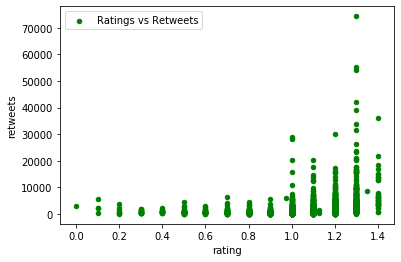

In [184]:
# create scatter plot of rating vs retweets
A1.plot(kind='scatter', x='rating', y='retweets', color='Green', label='Ratings vs Retweets')

*Notes:*

we can see from the scatterplot above that as the rating column increases (so higher ratings) the number of retweets generally seems to be higher

##### Analysis 2 - Rating vs Likes

- plot the rating the dog received vs the number of likes the actual tweet got, to see if there is a correlation

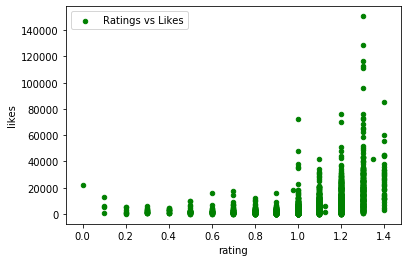

In [185]:
# create scatter plot of rating vs likes
A1.plot(kind='scatter', x='rating', y='likes', color='Green', label='Ratings vs Likes')

*Notes:*

Similar to that of rating vs retweets, there seems to be a pattern that indicates dog's with higher ratings favoured better in terms of the number of likes on their ratings tweet

##### Analysis 3 - Retweets vs Likes

Suspicion that there will be a strong positive correlation between the number of retweets & likes
- plot the number of retweets vs the number of likes the actual tweet got, to see if there is a correlation

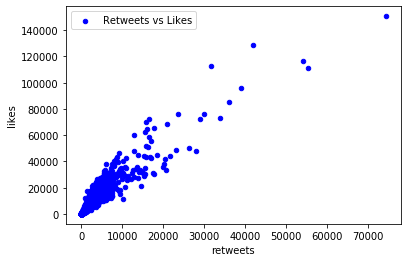

In [186]:
# create scatter plot of retweets vs likes
A1.plot(kind='scatter', x='retweets', y='likes', color='Blue', label='Retweets vs Likes')

*Notes:*

The graph above confirms that there appears to be strong positive correlation between the number of likes on a tweet and the number of retweets that tweet had

##### Analysis 4 - Most Common Dog Names

identify the 3 most common dog name from the WeRateDogs tweet archive

In [187]:
A1['name'].value_counts().head(3)

Oliver    12
Lucy      10
Cooper    10
Name: name, dtype: int64

We can see that Oliver, Charlie & Lucy are the most common names, all occurring at least 10 times across our tweet archive.

##### Analysis 5 - Most common dog stages identified within tweets

Provide a pie chat showing the breakdown of Doggo, Pupper, Puppo & Floofer from the tweet archive.

In [188]:
# select each tweet_id & it's corresponding dog stage value for summary (result stored in DF A2)
query2 = """
select distinct 
    tweet_id, dog_stage
        from WRD_Data
"""
A2 = ps.sqldf(query2)

In [189]:
dog_stages = A2['dog_stage'].value_counts()
print(dog_stages)

pupper      212
doggo        69
puppo        23
multiple     10
floofer       9
Name: dog_stage, dtype: int64


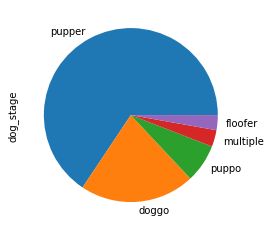

In [190]:
dog_stages.plot.pie()

We can see that where a dog stage was identified from the tweet text, "pupper" is the most prevalent. "Doggo" is also common, but "floofer" & "puppo" are not seen as much. There is also a small segment where "multiple" dog stages are present in a tweet.

##### End